In [2]:
import os
import time
import warnings
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.callbacks import TensorBoard
from keras import optimizers
from keras.models import Sequential, load_model, save_model
from keras import backend as K
import tensorflow as tf
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from itertools import count
import pandas as pd
from numpy import array
# from pykalman import KalmanFilter
from numpy import ma
global tr_date
tr_date = '2015/3/25'
##tr_date = '2005/1/7'
##tr_date = '2017/1/5'

global hist
hist = 100

In [5]:
import requests
url = "https://raw.githubusercontent.com/xiaoa5/stock-technical-analysis/master/000300bis.csv"
r = requests.get(url)

with open('000300bis.csv','w') as f:
  f.write(r.text)

In [3]:
from google.colab import files
# files.upload()
src = list(files.upload().values())[0]
open('my_test1.keras','wb').write(src)

Saving my_test1.keras to my_test1.keras


44776

In [16]:
model = load_model('my_test1.keras')

In [13]:
name='300'
stock_fath = '000'+name+'bis.csv'
# kf = KalmanFilter(transition_matrices = [1],
#                   observation_matrices = [1],
#                   initial_state_mean = 0,
#                   initial_state_covariance = 1,
#                   observation_covariance=1,
#                   transition_covariance=.01)
df = pd.read_csv(stock_fath, parse_dates=True)
def load_csv_data(df,col):  
    data_pandas = df[col]
    data = data_pandas .to_numpy()
    result = data
    return result

def normalise_windows(window_data):
    
    normalised_window = [((float(p) / float(window_data[0])) - 1) for p in window_data]
        
    return array(normalised_window)

In [10]:
class stock_env:
    def __init__(self):
        print ("init")
        self.price1 = load_csv_data(df,'close')
        self.price2 = load_csv_data(df,'open')
        # self.kalman,_ = kf.filter(self.price1)
    
        self.dates = df['date']
        self.hist = hist
        self.test_episode = len(self.price1) - self.hist - 2
        self.train_done = False
        self.test_done = False
        self.budget = 10000
        self.num_stocks = 0
        self.tr = 50/100000   #25

       
    def reset(self):   
        global steps_done
        steps_done = 0
        self.budget = 10000
        self.num_stocks = 0
        self.train_done = False
        self.test_done = False
        
        state =self.price1[steps_done:steps_done+self.hist]
        # kal = float(self.kalman[steps_done+self.hist+1])
        return state

    def step(self, action): 
        global steps_done
        steps_done += 1

        if steps_done > self.test_episode:
            self.test_done = True
        

        pre_price = float(self.price2[steps_done + self.hist-1+1])
        # pre_kal = float(self.kalman[steps_done+self.hist-1+1])
        pre_portfolio = self.budget + self.num_stocks * pre_price
        pre_date = self.dates[steps_done + self.hist-1+1]
        if action == 0 and pre_price >0: #buy
                    
            while self.budget >= pre_price*(1+self.tr):           
                self.budget -= pre_price *(1+self.tr)
                self.num_stocks += 1
        elif action == 1 and pre_price >0:       #sell
           
            while self.num_stocks > 0:       
                self.budget += pre_price*(1-self.tr)
                self.num_stocks -= 1
        else:
            pass

        try:

            state = self.price1[steps_done:steps_done+self.hist]
            price = float(self.price2[steps_done + self.hist+1])
            # kal = float(self.kalman[steps_done+self.hist+1])
            portfolio = self.budget + self.num_stocks * price
            date = self.dates[steps_done + self.hist+1]
            if date == tr_date:
                self.train_done = True

        except:
            pass
        return (state,self.train_done,self.test_done,pre_price,pre_portfolio,pre_date) #,pre_kal)

In [11]:
def select_action(state):
    
    state1 = state.copy()
    m1 = state1[-1]
    m80 = normalise_windows(state1[-80:])
    data = np.reshape(m80,(1,80,1))
    
    predicted = model.predict(data)
    predict_price = (predicted[0][0] +1)*state1[-80]
    
    m5 = state1[-5:].mean()
    m10 = state1[-10:].mean()
    m13 = state1[-13:].mean()
    m20 = state1[-20:].mean()
    m30 = state1[-30:].mean()
    m60 = state1[-60:].mean()


    try:

        if predict_price > m30:
            idx = 0
        else:
            idx = 1
    except:
        idx = 1
    
    
    return idx


In [14]:
env = stock_env()

results = []
profits = []

benchresults = []
dates = []
colors = []


init


In [17]:
# Initialize the environment and state
state = env.reset()
tr_done = False
ts_done = False
record = False

for t in count(1):    
    action = select_action(state) 
    if action == 0: #buy
        color = 1.0
    else :
        color = 0.0
    next_state,  tr_done, ts_done,price,portfolio,date = env.step(action)
    if t == 0:
        zero_portfolio = portfolio
        zero_value = price
    if date == tr_date:
        ref_portfolio = portfolio
        ref_value = price
        record = True
    if record is True:            
        tt = ref_portfolio * price/ref_value        
        results.append(portfolio)
        benchresults.append(tt)
        dates.append(date)
        colors.append(color)           
    if ts_done:
        action = select_action(next_state)
        if action == 0: #buy
            advise = 'Buy'
        else :
            advise = 'Sell'
        break
            
    state = next_state

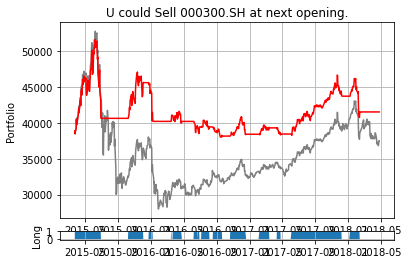

Complete : next opening U should Sell


In [18]:
import matplotlib.cm as cm       
dates = pd.to_datetime(dates)
ax1 = plt.subplot2grid((20,1), (0,0), rowspan=18, colspan=1)
##ax1.set_yscale("log")
plt.title('U could '+advise+' 000'+name+'.SH at next opening.')
plt.ylabel('Portfolio ')

plt.grid(True)
ax2 = plt.subplot2grid((20,1), (19,0), rowspan=1, colspan=1, sharex=ax1)
plt.ylabel('Long') 
plt.grid(True)

ax1.plot(dates, benchresults, 'grey',label='benchmark')   
ax1.plot(dates, results, 'red',label='agent')   

ax2.fill_between(dates, colors, 0)

plt.show()

print('Complete : next opening U should', advise)